<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter4GeometricImaging/codedApertureTomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Coded Aperture Tomography
###David Brady
### University of Arizona

Section 4.4 of **Computational Optical Imaging**

### Python modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import files
from scipy import signal
from scipy import integrate
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist


2024-10-02 15:24:13.784046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 15:24:13.861121: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-02 15:24:14.170129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-10-02 15:24:14.170170: W tensorflow/compiler/xla/stream_executor/platfo

## Forward Model

We consider an $N\times N$ object space a distance $l$ away from a 1D coded aperture, which is in turn a distance $d$ away from a detector array.
Describing the cells of the object with coeffients $lm$, the center position of the $lm^{th}$ cell is $l\Delta$, $d+ m\Delta$. However, we wish here to form a vector matrix forward model with a raster scan index of the pixels. Letting $j$ range from 1 to $N^2$, the 2D index of the $j^{th}$ pixel is
$l= {\rm mod}(j,N)$, $m=Z_o+\Delta {\rm floor}(j/N)$, where as in text figure 4.21, $Z_o$ is the range from front of th object to the detector array.

 The center position of the the $j^{th}$ element of the object is
$$
p_j=[\Delta {\rm mod}(j,N),Z_o+\Delta {\rm floor}(j/N)]
$$
The $j^{th}$ element projects the pattern
$$
g_j(x)=t\left (\frac{x+ \frac{l}{z_j}x_j}{1+\frac{l}{z_j}} \right )
$$
Again with reference to figure 4.21, $l$ is the range from the code to the detector array.

Measurements are discretely samples such that for the $i^{th}$ measurement we can define
$h_{ij}=\int g_j(x) {\rm rect}(x-i \Delta -x_o) dx$

$t(x)$ is defined over $x=[-\frac{N}{2} \Delta, \frac{N}{2} \Delta]$ and takes the form
$$
t(x)=\sum_{-\frac{N}{2}}^{\frac{N}{2}}t_n {\rm rect}(x-n\Delta )
$$
where $t_p$ is the code pattern.

In [12]:
#
#
#
#
l= 5
z=2*l
delta=1
N=28
M=128
code=np.random.randint(0,2,M)
def t(x):
  t=code[np.int64(np.floor((x+M/2)/delta))]
  return t
vt=np.vectorize(t)
def p(j):
  xj, yj=delta*divmod(j,N)
  xj=xj-N*delta/2
  yj=yj+z
  return xj, yj
def g(j,x):
  g=t((x+(l/p(j)[1])*p(j)[0])/(1+(l/p(j)[1])))
  return g
def h(i,j):
  h=integrate.quad(lambda x: g(j,x), (i-M/2)*delta-delta/2,(i-M/2)*delta +delta/2)[0]
  return h
H=np.zeros((M,N**2))
for j in range(N**2):
  for i in range(M):
    H[i,j]=h(i,j)






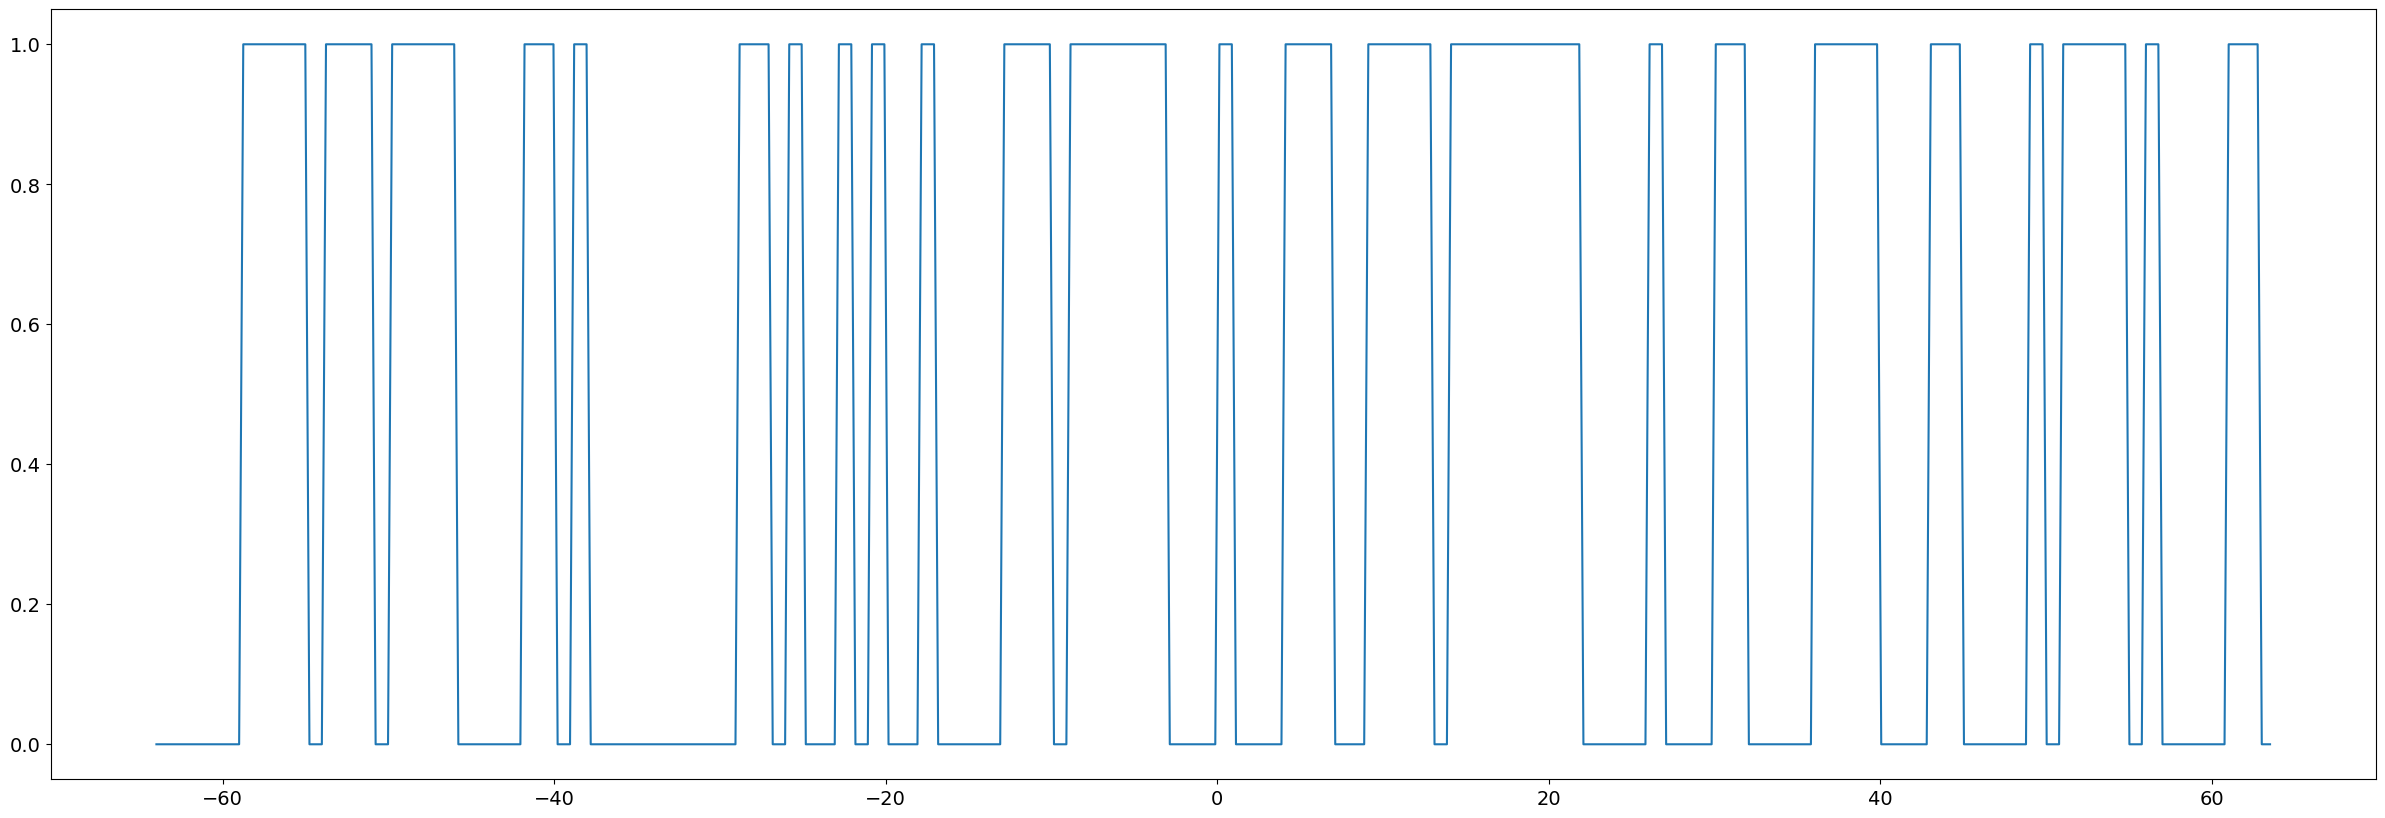

In [13]:
xspace=np.linspace(-M*delta/2,(M-1)*delta/2,512)
plt.plot(xspace,vt(xspace))

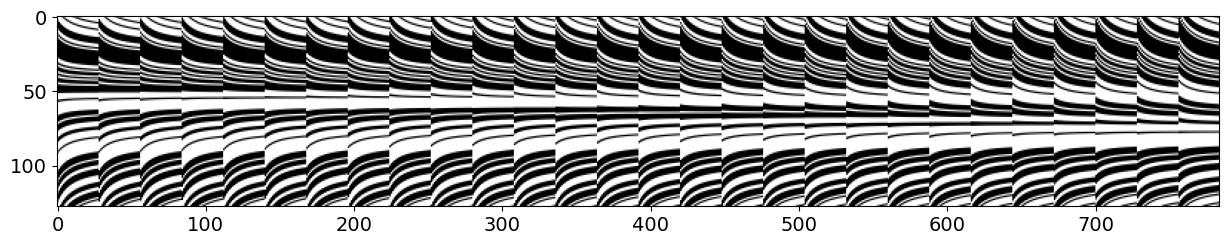

In [30]:
plt.figure(figsize=(15, 7))
plt.imshow(H, cmap='gray')
plt.savefig('codedApertureTomographyH.pdf')
#files.download('codedApertureTomographyH.pdf')

We can visualize the projection that each row of H makes on the N by N object space

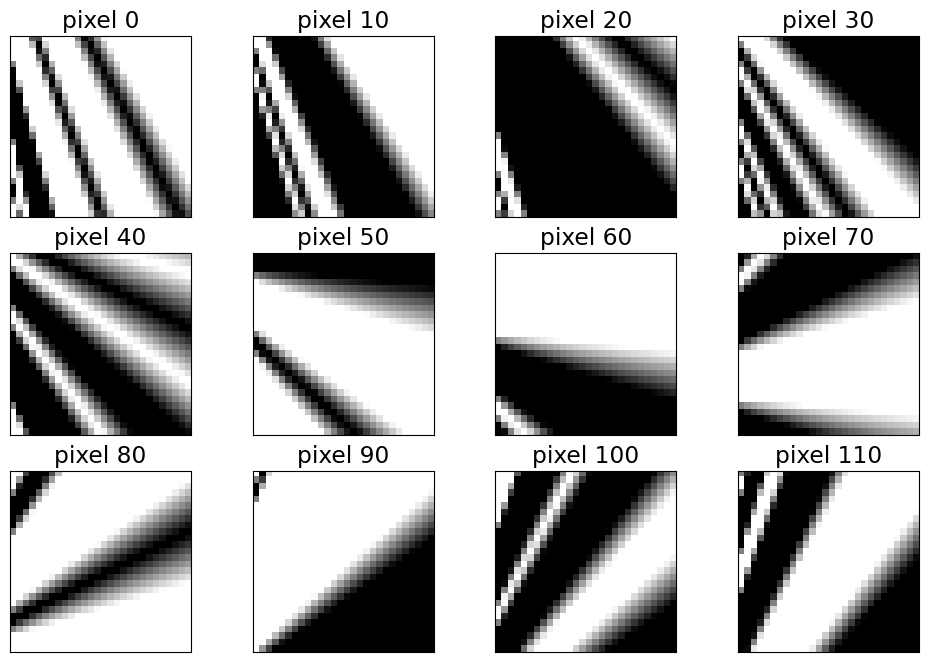

In [31]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 14})
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(H[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('pixel '+str(10*i))
plt.savefig('codedApertureTomographyMeasurements.pdf')
#files.download('codedApertureTomographyMeasurements.pdf')


In [32]:
u, lam, vh = np.linalg.svd(H)
ph=np.linalg.pinv(H)

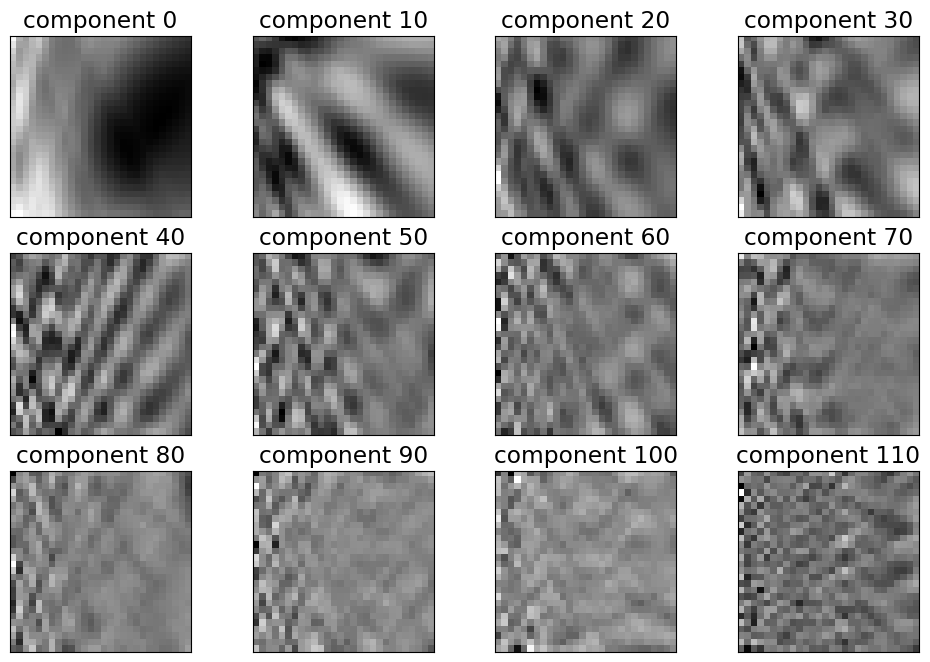

In [33]:

plt.figure(figsize=(12, 8))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(vh[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('component '+str(10*i))
plt.savefig('codedApertureTomographySV.pdf')
#files.download('codedApertureTomographySV.pdf')


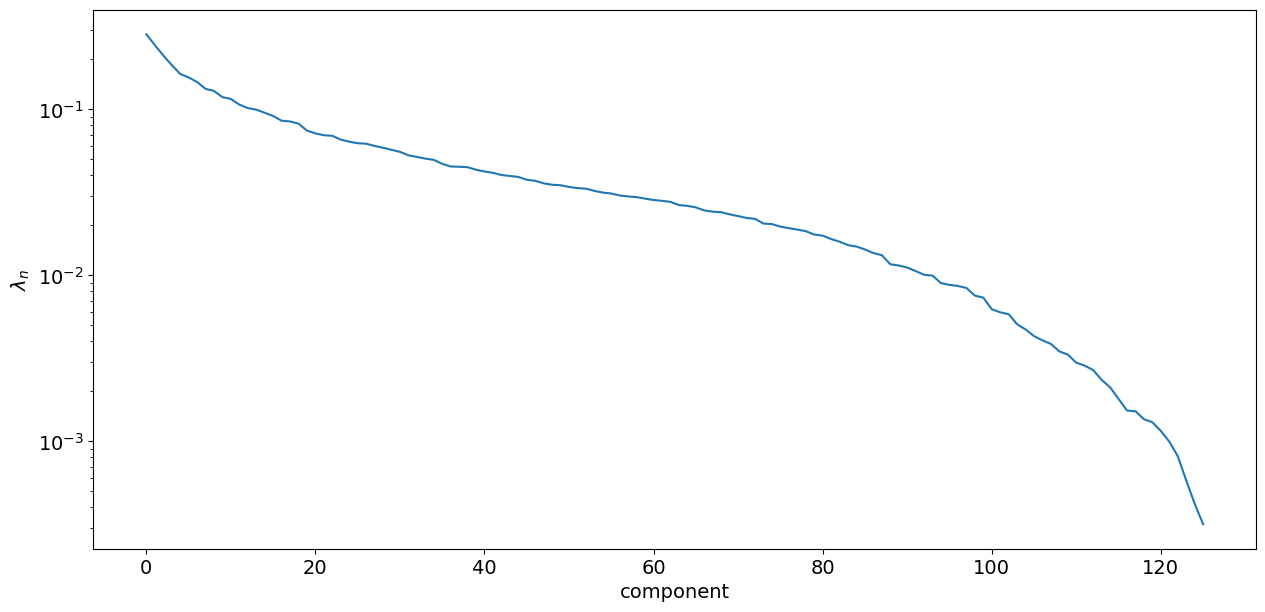

In [34]:
plt.figure(figsize=(15, 7))
plt.semilogy(lam[1:127]/lam[0])
plt.xlabel('component')
plt.ylabel(r'$\lambda_n$')
plt.savefig('codedApertureTomographySVDlambda.pdf')
#files.download('codedApertureTomographySVD.pdf')


# Neural Compressive Tomography

## Image database

In [35]:
# load the mnist dataset of characters


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

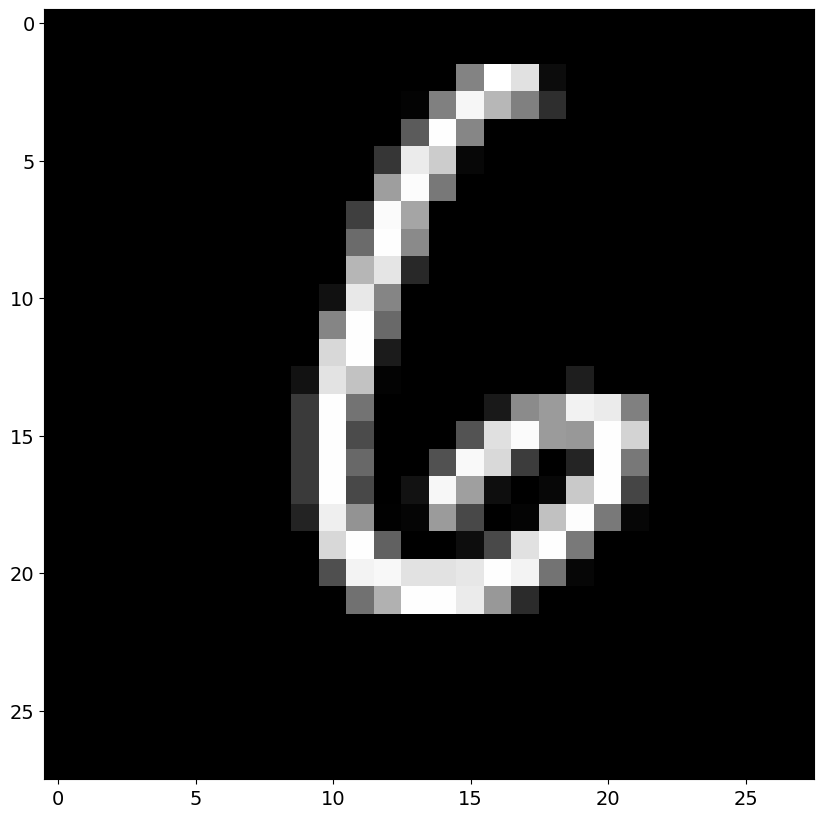

In [20]:
plt.imshow(x_train[32],cmap='gray')

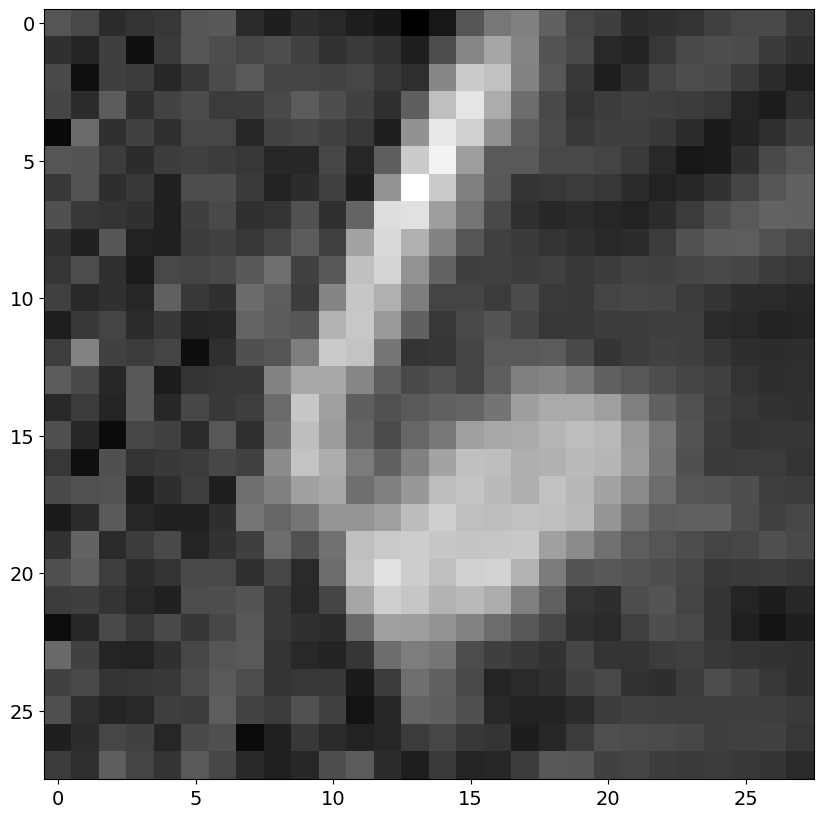

In [36]:
plt.imshow(np.reshape(np.matmul(np.linalg.pinv(H),np.matmul(H,np.reshape(x_train[32],N**2))),(N,N)))

###  prepare training data

In [37]:



g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= np.reshape(np.matmul(ph,np.matmul(H,np.reshape(x_test[pop],N**2))),(N,N))
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=np.reshape(np.matmul(ph,np.matmul(H,np.reshape(x_train[pop],N**2))),(N,N))
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), N, N, 1))
x_test = np.reshape(x_test, (len(x_test), N, N, 1))
g_train = np.reshape(g_train, (len(g_train), N, N, 1))
g_test = np.reshape(g_test, (len(g_test), N, N, 1))

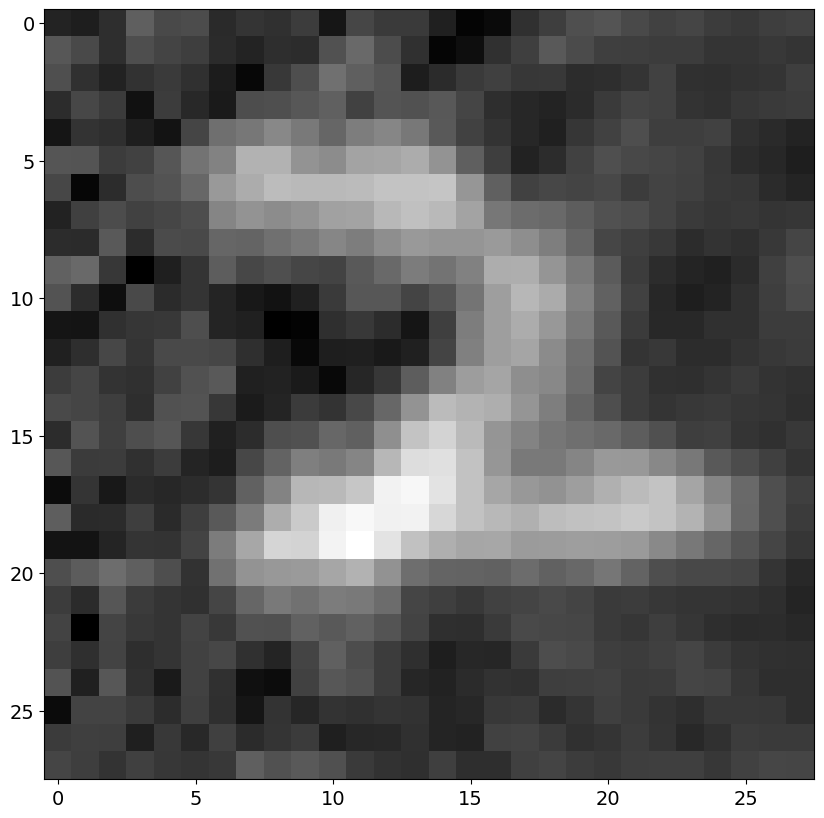

In [38]:
plt.imshow(g_test[1932].reshape(N, N))

### Encoder/denoising model

In [39]:
inputs=keras.Input(shape=(N, N, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        16416     
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                 

### Training

In [40]:
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/30
469/469 [==============================] - 10s 20ms/step - loss: 0.0163 - val_loss: 0.0093
Epoch 2/30
469/469 [==============================] - 9s 20ms/step - loss: 0.0087 - val_loss: 0.0077
Epoch 3/30
469/469 [==============================] - 9s 20ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 4/30
469/469 [==============================] - 9s 20ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 5/30
469/469 [==============================] - 9s 20ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 6/30
469/469 [==============================] - 9s 20ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 7/30
469/469 [==============================] - 9s 20ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 8/30
469/469 [==============================] - 9s 20ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 9/30
469/469 [==============================] - 10s 20ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 10/30
469/469 [==============================] - 9s 20ms/step - loss: 0.0054 - val_

### Examples of subsampled and estimated images

1/1 [==============================] - 0s 10ms/step


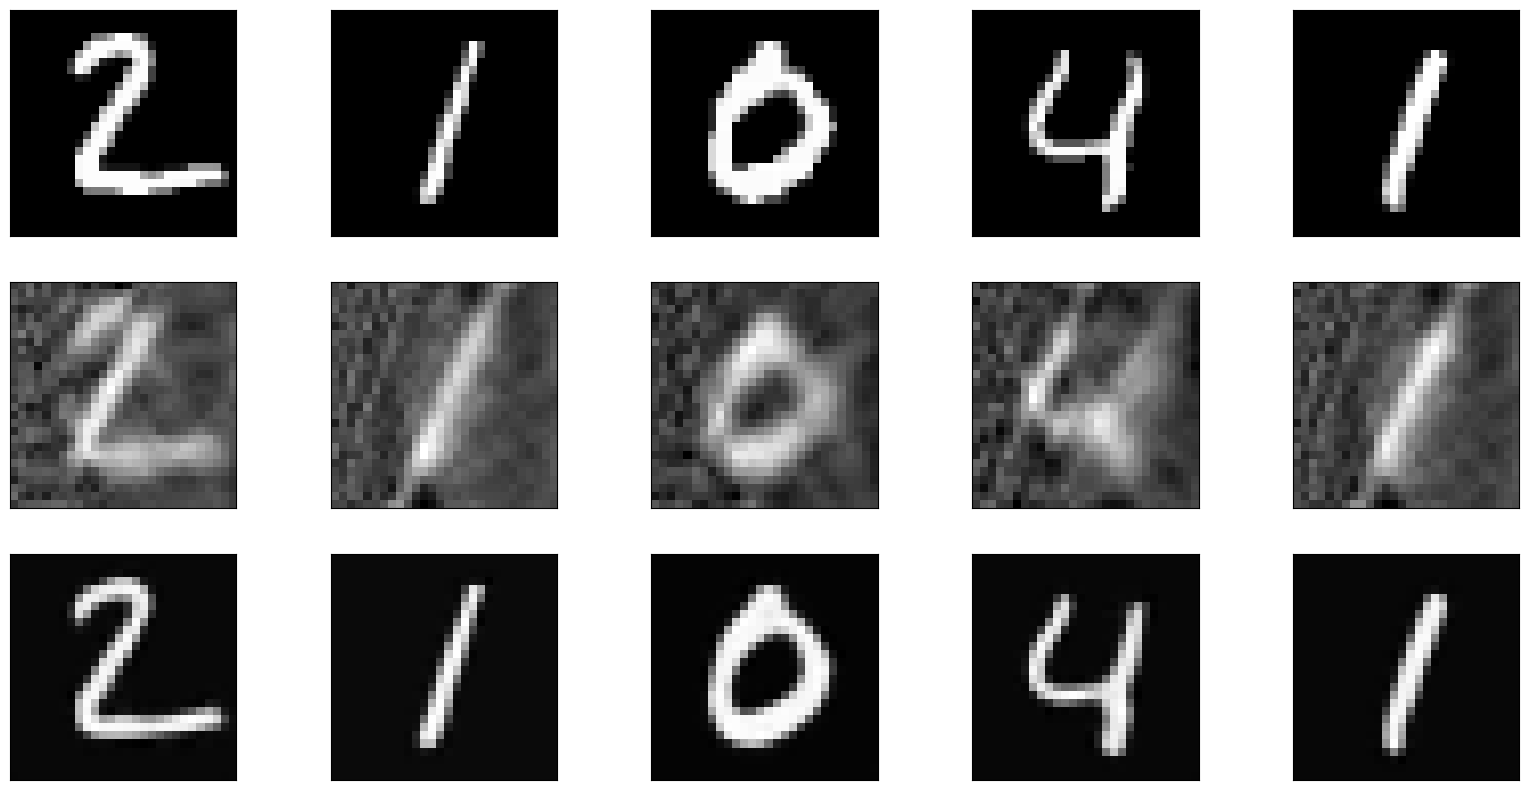

In [41]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('codedApertureTomography.pdf')
#files.download('codedApertureTomography.pdf')